# **Influence Calculation Outline**

In [1]:
%load_ext autoreload
%autoreload 2

Necessary imports.

In [2]:
import gin
import h5py
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import influence
import models
import utils

from circle import CircleEnv
from dqn import DQN

# Load configuration for DQN and model
gin.parse_config_file('configs/influence/influence.gin')

plt.style.use('dark_background')

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


First we train our __oracle network__.

Episode: 81 | Start: ( 3.00,  0.25) | Return:  1.40 | e: 0.9801
Episode: 82 | Start: (-0.25,  3.50) | Return:  0.98 | e: 0.9606
Episode: 83 | Start: (-2.00, -2.00) | Return:  1.42 | e: 0.9415
Episode: 84 | Start: (-1.75,  0.00) | Return:  3.30 | e: 0.9227
Episode: 85 | Start: (-0.75,  2.50) | Return:  2.09 | e: 0.9044
Episode: 86 | Start: ( 3.75, -0.50) | Return:  0.95 | e: 0.8864
Episode: 87 | Start: ( 2.50, -1.00) | Return:  2.75 | e: 0.8687
Episode: 88 | Start: ( 2.50, -1.25) | Return:  2.09 | e: 0.8515
Episode: 89 | Start: (-1.00,  4.00) | Return:  1.00 | e: 0.8345
Episode: 90 | Start: (-3.25,  2.25) | Return:  1.11 | e: 0.8179
Episode: 91 | Start: ( 0.00, -0.75) | Return: 24.24 | e: 0.8016
Episode: 92 | Start: ( 0.50, -2.75) | Return:  3.02 | e: 0.7857
Episode: 93 | Start: ( 1.25, -1.50) | Return: 14.53 | e: 0.7700
Episode: 94 | Start: (-0.50, -3.25) | Return:  1.67 | e: 0.7547
Episode: 95 | Start: (-1.00,  3.75) | Return:  0.94 | e: 0.7397
Episode: 96 | Start: ( 0.50, -1.00) | Re

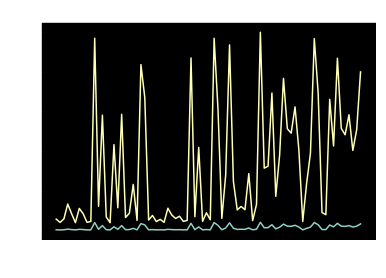

In [3]:
%%time
explore_episodes = 80
episodes = 80
steps = 25

oracle = DQN()
oracle.model.save('data/circle/init_models/oracle_init_model.h5')
oracle.target_model.save('data/circle/init_target_models/oracle_init_target_model.h5')

env = CircleEnv()

# Prepolute experience buffer with exploratory experiences (i.e. epsilon=1)
# I've found this to be the best way to train the agent with relatively few samples
for episode in range(explore_episodes):
    state = env.reset()
    for step in range(steps):
        action = env.sample() # Let the environment pick the next action randomly
        next_state, reward, done = env.step(action)
        oracle.remember((state, action, reward, next_state, episode, step, done))
        state = next_state
        
        if done or step==steps-1:
            break

rewards = []
# Note that episodes have this range since we already had episodes 0-79 in the exploration step
for episode in range(explore_episodes+1, episodes+explore_episodes+1):
    state = env.reset()
    start = state
    total_reward = 0
    
    # TODO: Consider range(1, steps+1)
    for step in range(steps):
#         env.render()
        action = oracle.act(state)
        next_state, reward, done = env.step(action)
        oracle.remember((state, action, reward, next_state, episode, step, done))
        oracle.replay()
        state = next_state
        total_reward += reward
        
        if done or step==steps-1:
            rewards.append(total_reward)
            print("Episode: {:2} | Start: ({:5.2f}, {:5.2f}) | Return: {:5.2f} | e: {:.4f}".format(episode, start[0], start[1], total_reward, oracle.epsilon))
            break

        if step%10==0 and step>0:
            if oracle.epsilon >= oracle.epsilon_min:
                oracle.epsilon *= oracle.epsilon_decay
            oracle.update_target_model()

oracle.save_training_data('data/circle/training_data/oracle_training_data.pkl')
oracle.model.save('data/circle/models/oracle_model.h5')

# Graph average reward during training
plt.plot(np.array(rewards)/steps)
plt.title('Average Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Avg. Reward')

plt.plot(rewards)
plt.title('Reward per Episode')

Load and setup necessary data.

In [4]:
oracle_model = 'data/circle/models/oracle_model.h5'
oracle_init_model = 'data/circle/init_models/oracle_init_model.h5'
oracle_init_target_model = 'data/circle/init_target_models/oracle_init_target_model.h5'
oracle_training_data = 'data/circle/training_data/oracle_training_data.h5'

training_data = pd.read_pickle(oracle_training_data)
unique_states = training_data[['state_x', 'state_y']].drop_duplicates()

# Get the optimal actions our oracle takes on the unique states seen in training data 
oracle_actions = utils.get_agent_actions(oracle, unique_states.to_numpy())
oracle_q_vals = utils.get_q_values(oracle.model, unique_states.to_numpy())
oracle_q_vals = pd.DataFrame(oracle_q_vals, columns=['qval_1', 'qval_2', 'qval_3', 'qval_4'])
test_data = unique_states.copy(deep=True).reset_index(drop=True)
test_data = pd.concat((test_data, oracle_q_vals), axis=1)
test_data['action'] = oracle_actions
test_data.to_pickle('data/circle/test_data/oracle_test_data.pkl')

training_data.info()
print('='*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
state_x         40000 non-null float64
state_y         40000 non-null float64
action          40000 non-null int64
reward          40000 non-null float64
next_state_x    40000 non-null float64
next_state_y    40000 non-null float64
episode         40000 non-null int64
step            40000 non-null int64
done            40000 non-null bool
dtypes: bool(1), float64(5), int64(3)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
state_x    1035 non-null float64
state_y    1035 non-null float64
qval_1     1035 non-null float32
qval_2     1035 non-null float32
qval_3     1035 non-null float32
qval_4     1035 non-null float32
action     1035 non-null float64
dtypes: float32(4), float64(3)
memory usage: 40.5 KB


Sanity check - training a new agent on the entire training dataset should be completely consistent.

In [ ]:
%%time
test_agent = DQN()
test_agent.model.load_weights(oracle_init_model)
test_agent.target_model.load_weights(oracle_init_target_model)

utils.train_agent_offline(test_agent, training_data.to_numpy())
test_agent_actions = utils.get_agent_actions(test_agent, test_data[['state_x', 'state_y']].to_numpy())
cons = utils.agent_consistency(test_agent_actions, test_data['action'].to_numpy())
print(cons)
assert cons == 1.0

In [ ]:
def action_to_vec(actions):
    action_map = {
        0: np.array([0, 0.25]),
        1: np.array([0, -0.25]),
        2: np.array([-0.25, 0]),
        3: np.array([0.25, 0])
    }
    
    vector_actions = np.empty((len(actions), 2))
    for i, action in enumerate(actions):
        vector_actions[i] = action_map[action]
    
    return vector_actions

In [ ]:
%%time
state = training_data.iloc[45]
print(state.state_x, state.state_y)

# Note: Influence function expects training_data and test_data to be Pandas DataFrames
influence.influence2(state, training_data, test_data, oracle_init_model, oracle_init_target_model, 'test.hdf5')
ft, pt, ftqv, ptqv = None, None, None, None
with h5py.File('test.hdf5', 'r') as f:
    ft, pt, ftqv, ptqv = f['ft'][:], f['pt'][:], f['ft_q_values'][:], f['pt_q_values'][:]

In [ ]:
ft_actions = np.argmax(ftqv, axis=1)
ft_actions = action_to_vec(ft_actions)
ft = training_data.iloc[ft]
oracle_actions = test_data['action'].to_numpy()
oracle_actions = action_to_vec(oracle_actions)
oracle_q_values = test_data.loc[:, 'qval_1':'qval_4'].max(axis=1).to_numpy()

removed_ft_states = training_data[~training_data.isin(ft).all(1)]

In [ ]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20, 20))
goal1 = matplotlib.patches.Circle((0, 0), 1, fill=False, color='orange', linestyle='--')
removed_point = matplotlib.patches.Circle((state.state_x, state.state_y), .1, fill=False, color='blue')
quiver1 = ax1.quiver(test_data.state_x, test_data.state_y, ft_actions[:,0], ft_actions[:,1], ft_q_vals.max(axis=1), cmap='Reds')
ax1.scatter(removed_ft_states.state_x, removed_ft_states.state_y, marker='x', color='yellow')
ax1.add_artist(goal1)
ax1.add_artist(removed_point)
ax1.set_aspect('equal')
ax1.set_title('Visualizing DQN Policy (w/ a Full Trace Removed)')

goal2 = matplotlib.patches.Circle((0, 0), 1, fill=False, color='orange', linestyle='--')
quiver2 = ax2.quiver(test_data.state_x, test_data.state_y, oracle_actions[:,0], oracle_actions[:,1], oracle_q_values, cmap='Reds')
ax2.add_artist(goal2)
ax2.set_aspect('equal')
ax2.set_title('Visualizing DQN Policy')
fig.colorbar(quiver1, ax=ax1, label='Q-value', fraction=0.046, pad=0.04)
fig.colorbar(quiver2, ax=ax2, label='Q-value', fraction=0.046, pad=0.04)
fig.tight_layout()
fig.savefig('example_policy_viz.png', frameon=False)